# Example Measurements with Real Instruments

It's good to have 100% test coverage, but it's better to have actual instruments performing measurements.

Here we run some example measurements on the QCoDeS test setup rack using the new dataset's `Measurement` object. No drivers were modified to make this notebook run; the new dataset is indeed compatible with the existing drivers.

In [1]:
%matplotlib notebook
from time import sleep
import numpy as np
import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id

# Drivers
from qcodes.instrument_drivers.Keysight.KeysightAgilent_33XXX import WaveformGenerator_33XXX
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
from qcodes.instrument_drivers.Keysight.Infiniium import Infiniium

In [2]:
# initialisation

sr830 = SR830('SR830', 'GPIB0::8::INSTR')
key = WaveformGenerator_33XXX('Keysight', 'TCPIP0::K-33522B-00256::inst0::INSTR')
mso = Infiniium('MSO', 'TCPIP0::AGILENT-32C1770::inst0::INSTR')

station = qc.Station(key, mso, sr830)

qc.new_experiment(name='EMwRI', sample_name='no_sample')

\\tsclient\sourcecodes\qcodes\qcodes\instrument\parameter.py:209: UserWarning: Wrapping get method, original get method will not be directly accessible. It is recommended to define get_raw in your subclass instead.
  warnings.warn('Wrapping get method, original get method will not '


Connected to: Stanford_Research_Systems SR830 (serial:s/n48280, firmware:ver1.07) in 0.91s
Connected to: Agilent Technologies 33522B (serial:MY57800256, firmware:3.05-1.19-2.00-52-00) in 0.15s
Connected to: Agilent Technologies MSO8104A (serial:MY45001438, firmware:05.71.0000) in 0.08s


EMwRI#no_sample#14@./experiments.db
-----------------------------------

## Measurement 1: Frequency sweeps

We output a sine from the function generator to the lock-in. While sweeping the sine frequency, we record the demodulated R. We also play around a bit and vary the time constant.

In [3]:
###
# Instrument preparation

# Keysight
key.ch1.function_type('SIN')
key.ch1.amplitude_unit('VPP')
key.ch1.amplitude(0.01)
key.ch1.offset(0)
key.ch1.frequency(1e3)  # this will be varied below

# SR830
sr830.ch1_display('R')
sr830.time_constant(0.01)
sr830.sensitivity(0.1)
sr830.frequency(10e3)

Starting experimental run with id: 35


<IPython.core.display.Javascript object>


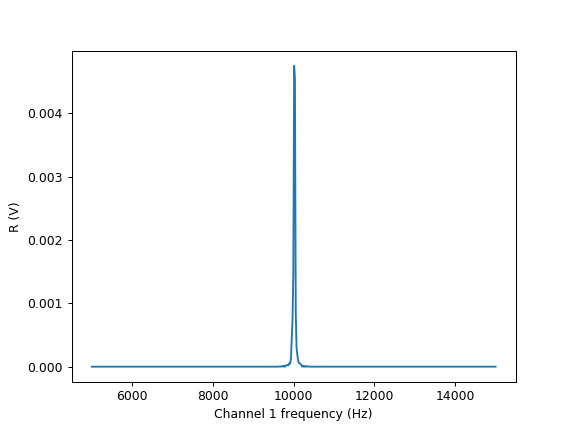

In [4]:
# set-up and tear-down actions
def setup():
    key.ch1.output('ON')

def teardown():
    key.ch1.output('OFF')

# simple frequency sweep

meas = Measurement()
meas.register_parameter(key.ch1.frequency)
meas.register_parameter(sr830.R, setpoints=(key.ch1.frequency,))
meas.add_before_run(setup, args=())
meas.add_after_run(teardown, args=())

tau = sr830.time_constant()

with meas.run() as datasaver:
    for freq in np.linspace(5e3, 15e3, 500):
        key.ch1.frequency(freq)
        sleep(tau)  # The SR830 does not wait by itself for the integration time to pass
        R = sr830.R()
        datasaver.add_result((key.ch1.frequency, freq),
                             (sr830.R, R))
        
    run_id = datasaver.run_id

plot = plot_by_id(run_id)

Starting experimental run with id: 36


<IPython.core.display.Javascript object>


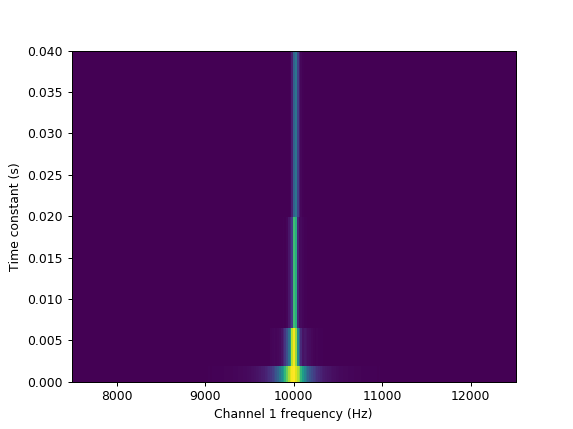

In [5]:
# Sweeping frequency and varying time constant

meas = Measurement()
meas.register_parameter(key.ch1.frequency)
meas.register_parameter(sr830.time_constant)
meas.register_parameter(sr830.R, setpoints=(key.ch1.frequency,
                                            sr830.time_constant))
meas.add_before_run(setup, args=())
meas.add_after_run(teardown, args=())


with meas.run() as datasaver:
    
    run_id = datasaver.run_id
    
    taus = [0.001, 0.003, 0.01, 0.03]
    freqs = np.linspace(7.5e3, 12.5e3, 250)
    
    for tau in taus:
        sr830.time_constant(tau)
        for freq in freqs:
            key.ch1.frequency(freq)
            sleep(tau)
            R = sr830.R()
            datasaver.add_result((sr830.time_constant, tau),
                                 (key.ch1.frequency, freq),
                                 (sr830.R, R))
            
plot = plot_by_id(run_id)

Looking at the above plot, we might rather want to record the log10 of the time constant. This is easy!

Starting experimental run with id: 37


<IPython.core.display.Javascript object>


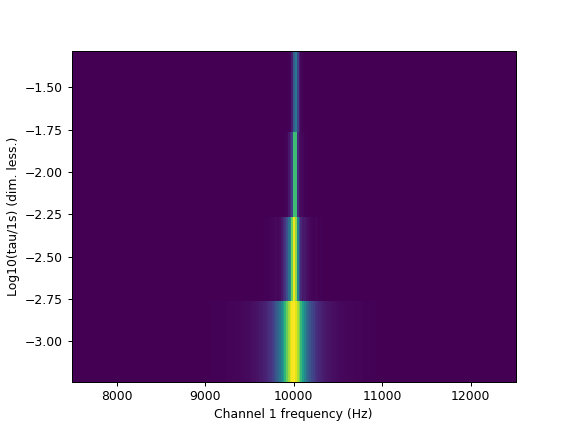

In [6]:
# Sweeping frequency and varying time constant, recording the logarithm

meas = Measurement()
meas.register_parameter(key.ch1.frequency)
meas.register_custom_parameter(name='log_tau', label='Log10(tau/1s)', unit='dim. less.')
meas.register_parameter(sr830.R, setpoints=(key.ch1.frequency,
                                            'log_tau'))
meas.add_before_run(setup, args=())
meas.add_after_run(teardown, args=())


with meas.run() as datasaver:
    run_id = datasaver.run_id
    
    taus = [0.001, 0.003, 0.01, 0.03]
    freqs = np.linspace(7.5e3, 12.5e3, 250)
    
    for tau in taus:
        sr830.time_constant(tau)
        for freq in freqs:
            key.ch1.frequency(freq)
            sleep(tau)
            R = sr830.R()
            datasaver.add_result(('log_tau', np.log10(tau)),
                                 (key.ch1.frequency, freq),
                                 (sr830.R, R))
            
plot = plot_by_id(run_id)

## Measurement 2: Triangle Traces

We record triangle pulses on an oscilloscope. We continuously emit triangle pulses, trigger, read one of them, and then sweep up the frequency.

In [7]:
# Prepare the scope
def scope_setup():
    mso.ch1.input('DC50')

    for i in range(4):
        # turn of all channels
        mso.channels[i].display(False)

    # switch channel 1 back on
    mso.ch1.display(True)
    mso.timebase_range(10e-3)
    mso.timebase_position(0.5*mso.timebase_range())
    mso.ch1.range(1.1)

    nPoints = 10000
    mso.acquire_points(nPoints)
    mso.acquire_sample_rate(nPoints/mso.timebase_range())

    mso.acquire_average(False)
    mso.trigger_enabled(True)
    mso.trigger_sweep('triggered')
    mso.trigger_edge_source('CHANnel1')
    mso.trigger_edge_slope('positive')
    mso.ch1.trigger_level(0.1)
    mso.trigger_sweep('single')
    
    mso.ch1.trace.prepare_curvedata()
    
    mso.write('run')

def keysight_setup():
    # Prepare the Keysight
    key.ch2.function_type('TRI')
    key.ch2.amplitude(0.5)
    key.ch2.frequency(1.3e2)
    key.ch2.burst_state('OFF')
    key.ch2.output('ON')
    
def keysight_teardown():
    key.ch2.output('OFF')

Starting experimental run with id: 40


<IPython.core.display.Javascript object>


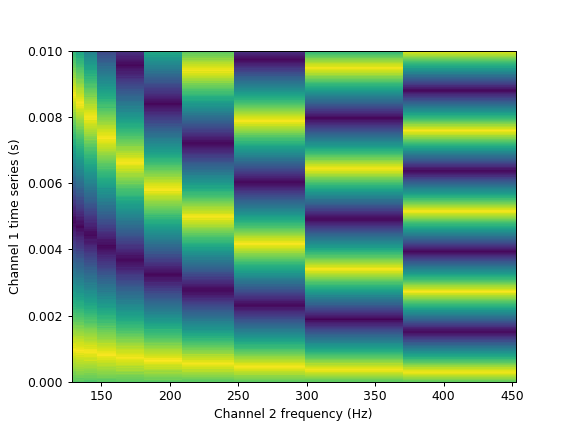

In [10]:
meas = Measurement()
meas.register_parameter(key.ch2.frequency)
meas.register_parameter(mso.ch1.trace, setpoints=(key.ch2.frequency,)) 
# the setpoints of the arrayparameter are registered automatically

meas.add_before_run(scope_setup, args=())
meas.add_before_run(keysight_setup, args=())
meas.add_after_run(keysight_teardown, args=())

mso.ch1.trace.prepare_curvedata()
with meas.run() as datasaver:
    for freqfactor in np.linspace(1, 1.25, 10):
        freq = key.ch2.frequency()*freqfactor
        key.ch2.frequency(freq)
        trace = mso.ch1.trace.get()
        datasaver.add_result((key.ch2.frequency, freq),
                             (mso.ch1.trace, trace))
        
plot = plot_by_id(datasaver.run_id)